In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier

# ✅Метрические алгоритмы(модели) 

<b>Метрические</b> алгоритмы, как можно понять из названия, устанавливают некую схожесть между объектами при помощи какой-нибудь метрики близости(этим может быть вполне стандартное Евклидово расстояние или, к примеру, косинусное сходство). Нам понадобится алгоритм K-Nearest-Neighbors(KNN) - <i>"Алгоритм K Ближайших Соседей"</i>. Подробнее про него можно прочитать <a href='https://habr.com/ru/articles/680004/'>тут</a>.

# ✅Основные метрики в задаче бинарной классификации

Пока мы вскользь обсуждали только Accuracy, но метрик гораздо больше! <b>ОБЯЗАТЕЛЬНО</b> прочесть про них <a href='https://habr.com/ru/companies/ods/articles/328372/'>здесь</a>.

Мы же пока подготовим данные для задачи классификации(скопируем код из блока классификации Титаника, пропустив EDA).

In [2]:
dataset = pd.read_csv('Titanic-Dataset.csv')
dataset.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)
dataset.fillna(-1, inplace=True)

dataset_coded = dataset.copy()

dataset_coded['Sex'] = np.where(dataset_coded['Sex'] == 'male', 1, 0)

cat_features = dataset_coded.drop(['Sex'], axis=1).select_dtypes(include=['object'])
cat_columns = list(cat_features.columns)
dataset_coded.drop(cat_columns, axis=1, inplace=True)
cat_features.replace(-1, '-1', inplace=True)

ohe = OneHotEncoder()
ohe.fit(cat_features)
coded_cat_features = pd.DataFrame(ohe.transform(cat_features).toarray(), columns=ohe.get_feature_names_out())

dataset_coded = pd.concat([dataset_coded, coded_cat_features], axis=1)

standard_scaler = StandardScaler()
standard_scaler.fit(dataset_coded.drop(['Survived'], axis=1))
dataset_coded = pd.DataFrame(standard_scaler.transform(dataset_coded.drop(['Survived'], axis=1)), columns=standard_scaler.get_feature_names_out())

dataset_coded = pd.concat([dataset_coded, dataset['Survived']], axis=1)

# ✅Посмотрим на распределение классов

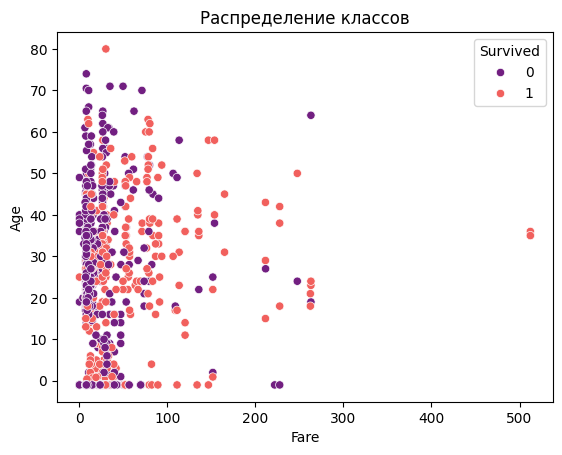

In [3]:
plot_classes = dataset[['Age', 'Fare', 'Survived']]
sns.scatterplot(data=plot_classes, x=plot_classes['Fare'], y=plot_classes['Age'], hue=plot_classes['Survived'], palette='magma')
plt.title('Распределение классов')
plt.show()

# ✅Разобьем данные на выборки

In [4]:
target = dataset['Survived']
X_train, X_test, y_train, y_test = train_test_split(dataset_coded.drop(['Survived'], axis=1), target, test_size=0.3, random_state=12)

# ✅Построим KNN и посмотрим на его результаты

In [5]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Отчет по классификации: \n')
pred = knn.predict(X_test)
print(classification_report(pred, y_test))

Отчет по классификации: 

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       175
           1       0.59      0.68      0.63        93

    accuracy                           0.72       268
   macro avg       0.70      0.71      0.70       268
weighted avg       0.74      0.72      0.73       268



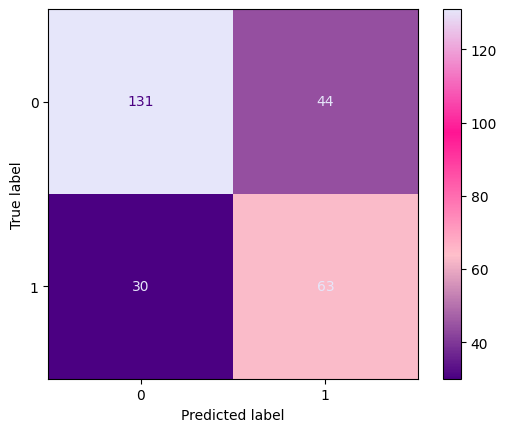

In [6]:
# посмотрим на матрицу ошибок
colors = ['indigo', 'pink', 'deeppink', 'lavender']
custom_cmap = LinearSegmentedColormap.from_list('RGBMap', colors, N=256)

cm = confusion_matrix(pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn.classes_)
disp.plot(cmap=custom_cmap)
plt.show()

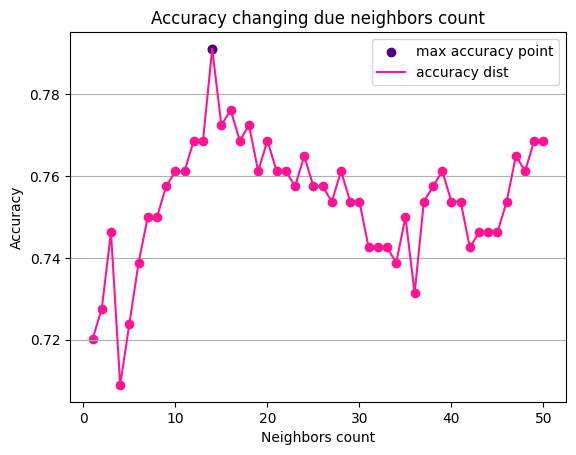

In [7]:
# подберем оптимальное число соседей эмпирическим методом "локтя"
# максимизировать будем accuracy
neighbors = [i for i in range(1, 51)]
accuracy_history = []

for neighbors_count in neighbors:
    model = KNeighborsClassifier(n_neighbors=neighbors_count)
    pred = model.fit(X_train, y_train).predict(X_test)
    accuracy_history.append(accuracy_score(pred, y_test))

plt.scatter(neighbors, accuracy_history, color='deeppink')
max_coord = [[neighbor, accuracy] for neighbor, accuracy in zip(neighbors, accuracy_history) if accuracy == max(accuracy_history)][0]
plt.scatter(max_coord[0], max_coord[1], color='indigo', label='max accuracy point')
plt.plot(neighbors, accuracy_history, color='deeppink', label='accuracy dist')

plt.title('Accuracy changing due neighbors count')
plt.xlabel('Neighbors count')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(axis='y')
plt.show()

In [8]:
# построим финальную модель
best_knn = KNeighborsClassifier(n_neighbors=max_coord[0])
best_knn.fit(X_train, y_train)
pred = best_knn.predict(X_test)
print('Отчет по классификации: \n')
pred = best_knn.predict(X_test)
print(classification_report(pred, y_test))

Отчет по классификации: 

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       189
           1       0.61      0.82      0.70        79

    accuracy                           0.79       268
   macro avg       0.76      0.80      0.77       268
weighted avg       0.82      0.79      0.80       268



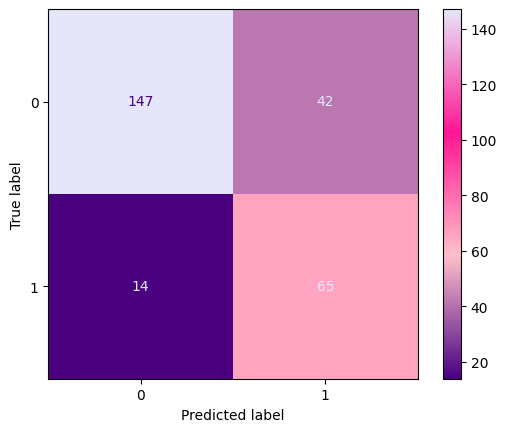

In [9]:
colors = ['indigo', 'pink', 'deeppink', 'lavender']
custom_cmap = LinearSegmentedColormap.from_list('RGBMap', colors, N=256)

cm = confusion_matrix(pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn.classes_)
disp.plot(cmap=custom_cmap)
plt.show()